In [1]:
#Graph Neural Net to Identify Kenneth Lay as important person in Enron Dataset
from extractous import Extractor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, time, csv
import regex as re
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.manifold import TSNE
from umap import UMAP
import networkx as nx
import scipy.stats as st

os.chdir("C:\Data")
print(f"Current working drive: {os.getcwd()}")
root_dir = "C:\Data\maildir"


<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:19: SyntaxWarning: invalid escape sequence '\D'
<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:19: SyntaxWarning: invalid escape sequence '\D'
C:\Users\graha\AppData\Local\Temp\ipykernel_21164\3456071438.py:17: SyntaxWarning: invalid escape sequence '\D'
  os.chdir("C:\Data")
C:\Users\graha\AppData\Local\Temp\ipykernel_21164\3456071438.py:19: SyntaxWarning: invalid escape sequence '\D'
  root_dir = "C:\Data\maildir"
c:\Users\graha\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Current working drive: C:\Data


In [2]:
#Importing data
valid_folders = {"inbox", "sent", "sent_items","_sent_mail"}
people = pd.read_csv(r"C:\Data\enron_hierarchy_people.csv")
people["folder_name"] = ( people["LastName"].str.lower() + "-" + people["FirstName"].str[0].str.lower())
valid_users = set(people["folder_name"])

emails = []

for dirpath, dirnames, filenames in os.walk(root_dir):
    folder_name = os.path.basename(dirpath).lower()
    user_name = os.path.basename(os.path.dirname(dirpath)).lower()

    # Keep only valid user folders and mail folders
    if user_name in valid_users and folder_name in valid_folders:
        for file in filenames:
            file_path = os.path.join(dirpath, file)
            try:
                if os.path.getsize(file_path) == 0:
                    continue
                with open(file_path, "r", encoding="latin1") as f:
                    content = f.read()
                    print(user_name)
                    emails.append({
                        "user_folder": user_name,
                        "folder": folder_name,
                        "path": file_path,
                        "content": content
                    })
            except Exception as e:
                print(f"Skipping {file_path} due to {e}")

emails_df = pd.DataFrame(emails)

allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p
allen-p


In [3]:
#Preprocessing
#We have to count all the sents and received from each person, I'm thinking we simply start by looking at
#amount of sent and received form each person to draw a simple hierarchy structure.
#Eventually we can have it so we eventually find a central node that is treated as "transient"

#First we will pull the to, from, date, and subject of each email into a dataset

embedding_data = []

for i, row in emails_df.iterrows():
    #Get the text from the row
    text = row['content']
    to_from = row['folder']

    from_match = re.search(r"^From:\s*(.*)", text, re.MULTILINE)
    to_match   = re.search(r"^To:\s*(.*)", text, re.MULTILINE)
    subject_match = re.search(r"^Subject:\s*(.*)", text, re.MULTILINE)
    date_match = re.search(r"^Date:\s*(.*)", text, re.MULTILINE)
    

    from_addr = from_match.group(1).strip() if from_match else None
    to_addr   = to_match.group(1).strip() if to_match else None
    subject_addr = subject_match.group(1).strip() if subject_match else None
    date_addr = date_match.group(1).strip() if date_match else None
    #Append it to the dataset above
    print(f"Appending email from: {from_addr}")
    embedding_data.append({
        "From": from_addr,
        "To": to_addr,
        "Date": date_addr,
        "Subject": subject_addr,
        "Type": to_from

    })

embedding_data = pd.DataFrame(embedding_data)


Appending email from: subscriptions@intelligencepress.com
Appending email from: arsystem@mailman.enron.com
Appending email from: prizemachine@feedback.iwon.com
Appending email from: louise.kitchen@enron.com
Appending email from: anchordesk_daily@anchordesk.zdlists.com
Appending email from: subscriptions@intelligencepress.com
Appending email from: exclusive_offers@sportsline.com
Appending email from: subscriptions@intelligencepress.com
Appending email from: arsystem@mailman.enron.com
Appending email from: anchordesk_daily@anchordesk.zdlists.com
Appending email from: heather.dunton@enron.com
Appending email from: msimpkins@winstead.com
Appending email from: msimpkins@winstead.com
Appending email from: renee.ratcliff@enron.com
Appending email from: wise.counsel@lpl.com
Appending email from: jsmith@austintx.com
Appending email from: richard.morgan@austinenergy.com
Appending email from: hunter.williams@grandecom.com
Appending email from: hunter.williams@grandecom.com
Appending email from: m

In [9]:
#Save it to csv so we don't have to read it in again
print("saving to csv")
embedding_data.to_csv("C:\Data\embedded_email_data.csv",index = False)

saving to csv


<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\D'
C:\Users\graha\AppData\Local\Temp\ipykernel_15400\1387360862.py:3: SyntaxWarning: invalid escape sequence '\D'
  embedding_data.to_csv("C:\Data\embedded_email_data.csv",index = False)


In [4]:
# Split multi-recipient "To" fields into lists
def split_recipients(to_field):
    if pd.isna(to_field):
        return []
    recipients = re.split(r'[;,]', str(to_field))
    return [r.strip() for r in recipients if r.strip() != ""]

# Create a new exploded DataFrame
embedding_data["To"] = embedding_data["To"].apply(split_recipients)
embedding_data = embedding_data.explode("To").reset_index(drop=True)

# Remove any empty rows (e.g., if 'To' was blank)
embedding_data = embedding_data[embedding_data["To"].notna() & (embedding_data["To"] != "")]

# Save the cleaned dataset
embedding_data.to_csv("embedded_email_data_expanded.csv", index=False)

In [11]:
#Here will just be some basic eda to get an idea for the subsetted dataset of 20 people

#Now lets verify the 20 people by checking the To parameter for all with inbox
unique_emails = embedding_data[embedding_data['Type'] == 'inbox']
unique_emails = unique_emails['To'].unique()
print(unique_emails)
print(len(unique_emails))
#This is hard to verify as often there are many people emailed at the same time.

#Subsetting data to only the 20 important emails
subset_embedding_data = embedding_data[embedding_data["To"].isin(people["Email"])]
print(f"Should be 20 people if comparing to original: {subset_embedding_data['To'].nunique()}")

['pallen@enron.com' 'k..allen@enron.com' 'wes.colwell@enron.com' ...
 'e-mail <.wendy@enron.com>' 'e-mail <.ronnie@enron.com>'
 'ckk@ascentgroup.com']
1922
Should be 20 people if comparing to original: 20


In [69]:
#Here we will construct a markov chain to infer who is higher level, my idea here being
#people like ceo's should be transient as emails should make their way up the chain.

#Preprocessing to develop the markov chain
# Only keep From and To columns

#Here we are building edge feature: to_from probabilities in edges

to_from_count = embedding_data[["From", "To"]].dropna()
to_from_count["From"] = to_from_count["From"].str.lower().str.strip()
to_from_count["To"]   = to_from_count["To"].str.lower().str.strip()

# All unique email addresses appearing anywhere
people = sorted(set(to_from_count["From"]) | set(to_from_count["To"]))

# Initialize square matrix of zeros
P = pd.DataFrame(0, index=people, columns=people, dtype=float)

# Count transitions
for _, row in to_from_count.iterrows():
    P.loc[row["From"], row["To"]] += 1

# Normalize rows to get transition probabilities
P = P.div(P.sum(axis=1), axis=0).fillna(0)

print(f"Built square transition matrix: {P.shape[0]}x{P.shape[1]}")

P.to_csv("P.csv",index=False)

Built square transition matrix: 6598x6598


In [ ]:
#Building Node feature: to-from emails
# send_counts = P.sum(axis=1).values   # total outgoing probability mass (should sum to 1)
# recv_counts = P.sum(axis=0).values   # total incoming probability mass

# Combine into a feature matrix (2 features per node)
#X = np.vstack([send_counts, recv_counts]).T

send = P.sum(axis=1).values
recv = P.sum(axis=0).values
ratio = send / (recv + 1e-6)
out_degree = (P.values > 0).sum(axis=1)
in_degree  = (P.values > 0).sum(axis=0)

#X = np.vstack([send, recv, ratio, out_degree, in_degree]).T

# Optional normalization
#X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-9)

# Convert to torch tensor
#x = torch.tensor(X, dtype=torch.float)

In [71]:
print(len(P))

###Testing

start_person = "kenneth.lay@enron.com"
v = np.zeros(len(P))
v[P.index.get_loc(start_person)] = 1.0  # initial probability mass

# Perform diffusion over k steps
for _ in range(5):
    v = v @ P.values  # Markov transitions

# Convert to readable ranking
result = pd.Series(v, index=P.index).sort_values(ascending=False)
print(result.head(10))

result.reset_index().rename(columns={"index": "Person", 0: "Probability"}).to_csv(f"markov_diffusion_results_for_{start_person}.csv", index=False)

6598
john.lavorato@enron.com     0.013529
sally.beck@enron.com        0.012957
e..haedicke@enron.com       0.011215
kenneth.lay@enron.com       0.010037
k..allen@enron.com          0.009584
greg.whalley@enron.com      0.008424
jeff.dasovich@enron.com     0.006276
louise.kitchen@enron.com    0.006128
jeff.skilling@enron.com     0.004560
tim.belden@enron.com        0.003798
dtype: float64


In [90]:
#Add feature - Eigenvector Centrality
G = nx.from_pandas_adjacency(P, create_using=nx.DiGraph)

# PageRank → captures influence / authority (robust for disconnected graphs)
pagerank = nx.pagerank(G, weight="weight", alpha=0.85)

# Betweenness → measures control of communication flow
bet_cent = nx.betweenness_centrality(G, weight="weight", normalized=True)

# Closeness → average distance to others (operational proximity)
close_cent = nx.closeness_centrality(G)

# Weighted degree values (for completeness)
in_deg_w  = dict(G.in_degree(weight="weight"))
out_deg_w = dict(G.out_degree(weight="weight"))

pr    = np.array([pagerank.get(n, 0) for n in P.index])
bet   = np.array([bet_cent.get(n, 0) for n in P.index])
close = np.array([close_cent.get(n, 0) for n in P.index])
in_deg = np.array([in_deg_w.get(n, 0) for n in P.index])
out_deg = np.array([out_deg_w.get(n, 0) for n in P.index])

X = np.vstack([
    send, recv, ratio,
    in_deg, out_deg,
    pr, bet, close
]).T

# Normalize (zero mean, unit variance)
X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-9)

# Convert to torch tensor for GNN
x = torch.tensor(X, dtype=torch.float)

In [91]:
#Next we need to start building the graph neural net

###First we need to build the P matrix into a form that can be analyzed by the neural net

# Extract edges (nonzero probabilities)
rows, cols = np.where(P.values > 0)
edge_index = torch.tensor([rows, cols], dtype=torch.long)
edge_weight = torch.tensor(P.values[rows, cols], dtype=torch.float)

# Initial node features (embeddings)
# Option 1: random initialization
#x = torch.randn((P.shape[0], 16))

# Build PyTorch Geometric Data object
data = Data(
    x=x,                     
    edge_index=edge_index,
    edge_weight=edge_weight
)

In [ ]:
#Graph Convolutional Network
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.out_channels = out_channels

    def forward(self, x, edge_index, edge_weight):
        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_weight=edge_weight)
        return x


#Contrastive Loss Function for GCN
class DeepGraphInfomax(torch.nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.weight = torch.nn.Parameter(torch.Tensor(encoder.out_channels, encoder.out_channels))
        torch.nn.init.xavier_uniform_(self.weight)
        
    def forward(self, x, edge_index, edge_weight):
        # Real embeddings
        h = self.encoder(x, edge_index, edge_weight)
        # Corrupted version (shuffle features)
        x_corrupt = x[torch.randperm(x.size(0))]
        h_corrupt = self.encoder(x_corrupt, edge_index, edge_weight)

        # Global summary vector (mean of node embeddings)
        s = torch.sigmoid(h.mean(dim=0))
        
        # Mutual information maximization
        pos = torch.matmul(h, torch.matmul(self.weight, s))
        neg = torch.matmul(h_corrupt, torch.matmul(self.weight, s))

        loss = -F.logsigmoid(pos).mean() - F.logsigmoid(-neg).mean()
        return loss, h

In [ ]:
#Train the model

encoder = GCNEncoder(in_channels=data.x.shape[1], hidden_channels=64, out_channels=32)
model = DeepGraphInfomax(encoder)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(400):
    model.train()
    optimizer.zero_grad()
    loss, h = model(data.x, data.edge_index, data.edge_weight)
    loss.backward()
    optimizer.step()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}")

Epoch 000, Loss: 1.4534
Epoch 020, Loss: 1.3532
Epoch 040, Loss: 1.3251
Epoch 060, Loss: 1.2303
Epoch 080, Loss: 1.1425
Epoch 100, Loss: 1.0799
Epoch 120, Loss: 1.0277
Epoch 140, Loss: 1.0119
Epoch 160, Loss: 0.9831
Epoch 180, Loss: 1.0418
Epoch 200, Loss: 1.0397
Epoch 220, Loss: 0.9564
Epoch 240, Loss: 1.0962
Epoch 260, Loss: 0.9158
Epoch 280, Loss: 0.9179
Epoch 300, Loss: 0.8904
Epoch 320, Loss: 0.9553
Epoch 340, Loss: 0.9097
Epoch 360, Loss: 0.9129
Epoch 380, Loss: 0.9180


In [94]:
embeddings = h.detach().numpy()
np.save("enron_markov_gnn_embeddings.npy", embeddings)

c:\Users\graha\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


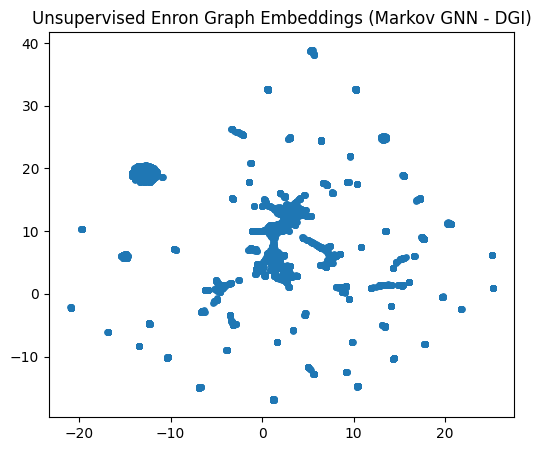

In [95]:
#Visualize results, must compress to two dimensions with TSNE

#z_2d = TSNE(n_components=2, random_state=1234).fit_transform(embeddings)
z_2d = UMAP(n_components=2, random_state=1234).fit_transform(embeddings)

plt.figure(figsize=(6,5))
plt.scatter(z_2d[:,0], z_2d[:,1], s=15)
plt.title("Unsupervised Enron Graph Embeddings (Markov GNN - DGI)")
plt.show()

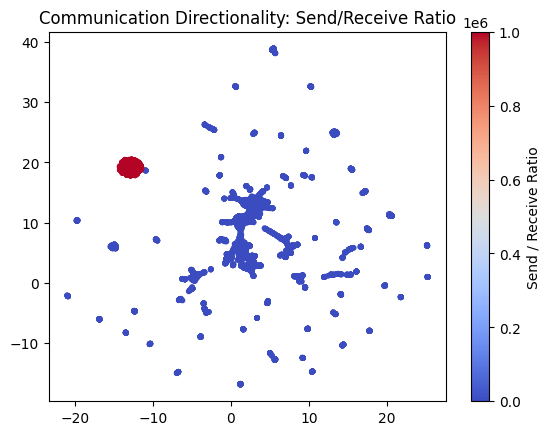

In [96]:
plt.scatter(z_2d[:,0], z_2d[:,1], c=send / (recv + 1e-6), cmap='coolwarm', s=10)
plt.title("Communication Directionality: Send/Receive Ratio")
plt.colorbar(label="Send / Receive Ratio")
plt.show()

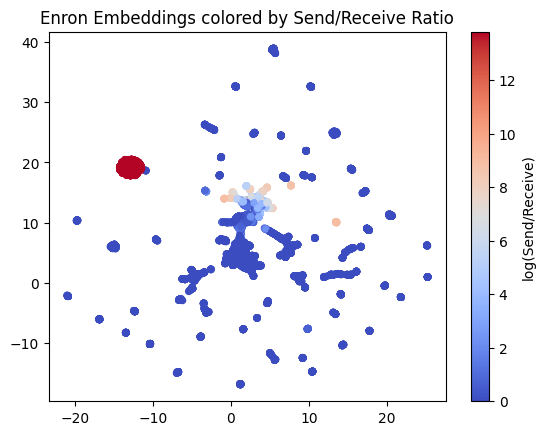

In [97]:
# Reduce to 2D for inspection
coords = pd.DataFrame(z_2d, columns=['x','y'], index=P.index)
coords['sent'] = send
coords['recv'] = recv
coords['ratio'] = send / (recv + 1e-6)
coords.sort_values('x').head(10)

plt.scatter(z_2d[:,0], z_2d[:,1],
            c=np.log1p(send / (recv + 1e-6)),
            cmap='coolwarm', s=20)
plt.title("Enron Embeddings colored by Send/Receive Ratio")
plt.colorbar(label="log(Send/Receive)")
plt.show()

c:\Users\graha\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


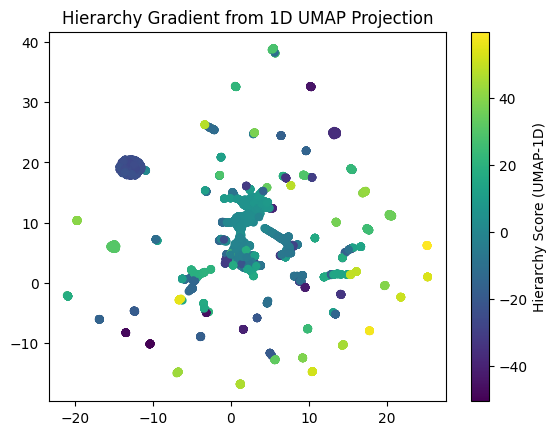

In [98]:
order_axis = UMAP(n_components=1, random_state=1234, metric="cosine").fit_transform(embeddings).ravel()

hierarchy_df = pd.DataFrame({
    "Email": P.index,
    "HierarchyScore": order_axis
}).sort_values("HierarchyScore", ascending=False)

hierarchy_df.head(15)

plt.scatter(z_2d[:,0], z_2d[:,1],
            c=order_axis, cmap="viridis", s=25)
plt.title("Hierarchy Gradient from 1D UMAP Projection")
plt.colorbar(label="Hierarchy Score (UMAP-1D)")
plt.show()


=== Level 1 - Executives ===


,Email,HierarchyScore,Level
4596,moses@enron.com,59.774738,Level 1 - Executives
1097,chris.behney@enron.com,59.773094,Level 1 - Executives
2598,holland.brown@mba02.bus.utexas.edu,59.772030,Level 1 - Executives
3772,laura.johnson@enron.com,59.768600,Level 1 - Executives
4870,patti.thomason@enron.com,59.759335,Level 1 - Executives
280,alents49@hotmail.com,59.758827,Level 1 - Executives
4683,neil.tarling@enron.com,59.758717,Level 1 - Executives
2321,geoffreymann@hotmail.com,59.758026,Level 1 - Executives
1086,cheryl.whittaker@usa.xerox.com,59.755722,Level 1 - Executives
5513,sam.leuschen@enron.com,59.755291,Level 1 - Executives



=== Level 2 - Senior Mgmt ===


,Email,HierarchyScore,Level
3739,lamoss@duke-energy.com,19.133530,Level 2 - Senior Mgmt
3876,linda.bryan@enron.com,19.088526,Level 2 - Senior Mgmt
5526,sandra.dial@enron.com,19.067862,Level 2 - Senior Mgmt
3622,kimberly.brown@enron.com,19.061186,Level 2 - Senior Mgmt
126,8777208398.4891940@pagenetmessage.net,19.053802,Level 2 - Senior Mgmt
3307,jporte1@columbiaenergygroup.com,19.051247,Level 2 - Senior Mgmt
1976,elizabeth.hernandez@enron.com,19.047512,Level 2 - Senior Mgmt
350,ami.chokshi@enron.com,19.043575,Level 2 - Senior Mgmt
5432,ross.bill@enron.com,19.018417,Level 2 - Senior Mgmt
6447,wade.price@enron.com,19.014166,Level 2 - Senior Mgmt



=== Level 3 - Staff/Mid ===


,Email,HierarchyScore,Level
989,carrie.slagle@enron.com,-1.656881,Level 3 - Staff/Mid
4146,mark.friedman@enron.com,-1.662391,Level 3 - Staff/Mid
4197,marsha.schiller@enron.com,-1.676595,Level 3 - Staff/Mid
3406,k..heathman@enron.com,-1.699402,Level 3 - Staff/Mid
1189,clarissa.garcia@enron.com,-1.715384,Level 3 - Staff/Mid
851,brian.stanley@enron.com,-1.728456,Level 3 - Staff/Mid
744,boardroom@enron.com,-1.740130,Level 3 - Staff/Mid
3293,joyce.dorsey@enron.com,-1.745896,Level 3 - Staff/Mid
6267,tom.wilbeck@enron.com,-1.747166,Level 3 - Staff/Mid
5026,plotkin.norman@enron.com,-1.755237,Level 3 - Staff/Mid



=== Level 4 - Assistants/Receivers ===


,Email,HierarchyScore,Level
762,bob_beauchamp@bmc.com,-23.918053,Level 4 - Assistants/Receivers
2344,georgette@hawkespeers.com,-23.919268,Level 4 - Assistants/Receivers
2127,ext.443@kor-seek.com,-23.920395,Level 4 - Assistants/Receivers
5311,rita.ramirez@enron.com,-23.920887,Level 4 - Assistants/Receivers
2972,jemer4@home.com,-23.924650,Level 4 - Assistants/Receivers
2397,glenn.sloan@enron.com,-23.925892,Level 4 - Assistants/Receivers
5960,steven.january@enron.com,-23.931107,Level 4 - Assistants/Receivers
4594,morrisjhd@aol.com,-23.931450,Level 4 - Assistants/Receivers
684,bianca_hayes@hotmail.com,-23.934103,Level 4 - Assistants/Receivers
366,amy.siedenburg@gs.com,-23.935560,Level 4 - Assistants/Receivers


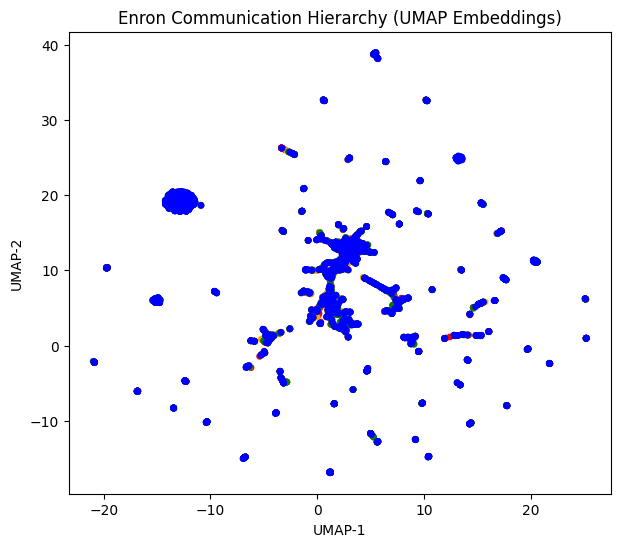

In [99]:
hierarchy_df["Level"] = pd.qcut(
    hierarchy_df["HierarchyScore"], 
    q=4, 
    labels=["Level 4 - Assistants/Receivers",
            "Level 3 - Staff/Mid",
            "Level 2 - Senior Mgmt",
            "Level 1 - Executives"]
)

for lvl in hierarchy_df["Level"].unique():
    print(f"\n=== {lvl} ===")
    display(hierarchy_df[hierarchy_df["Level"] == lvl]
            .sort_values("HierarchyScore", ascending=False)
            .head(10))
    
# Map levels to colors
color_map = {
    "Level 1 - Executives": "red",
    "Level 2 - Senior Mgmt": "orange",
    "Level 3 - Staff/Mid": "green",
    "Level 4 - Assistants/Receivers": "blue"
}

colors = hierarchy_df["Level"].map(color_map)

plt.figure(figsize=(7,6))
plt.scatter(z_2d[:,0], z_2d[:,1], c=colors, s=15)
plt.title("Enron Communication Hierarchy (UMAP Embeddings)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

hierarchy_df.to_csv("hierarchy.csv",index=False)